In [1]:
%load_ext autoreload
%autoreload 2
%cd /home/xux/Desktop/Enzyme_design/Savi_design/Savinase-engineering

/home/xux/Desktop/Enzyme_design/Savi_design/Savinase-engineering


In [2]:
import pandas as pd
import numpy as np

train = False

# Load round1 BPN hotspots & convert into Savinase index

In [3]:
import pandas as pd

df_hotspot =pd.read_csv('data/round1/hotspots/Subtilisin_BPN_hotspot.csv')

print(df_hotspot.columns, len(df_hotspot))

Index(['pos', 'mut_aas'], dtype='object') 25


In [4]:
import numpy as np

def convert_into_savinase_position(positions):
    """ Convert from BPN positions to savinase positions """
    uniq_pos = list(set(positions))
    uniq_pos_sorted = np.sort(uniq_pos).tolist()

    # Convert the positions into savinase positions
    savinase = 'AQSVPWGISRVQAPAAHNRGLTGSGVKVAVLDTGI*STHPDLNIRGGASFVPGEPST*QDGNGHGTHVAGTIAALNNSIGVLGVAPSAELYAVKVLGASGSGSVSSIAQGLEWAGNNGMHVANLSLGSPSPSATLEQAVNSATSRGVLVVAASGNSG*AGS***ISYPARYANAMAVGATDQNNNRASFSQYGAGLDIVAPGVNVQSTYPGSTYASLNGTSMATPHVAGAAALVKQKNPSWSNVQIRNHLKNTATSLGSTNLYGSGLVNAEAATR'

    sav_pos = []
    idx_diff = 0
    for i, aa in enumerate(savinase):
        if aa == '*': idx_diff += 1

        if i+1 in uniq_pos_sorted:
            sav_pos.append(i+1 - idx_diff)
    
    # restore the original order
    pos_mapping = dict(zip(uniq_pos_sorted, sav_pos))
    sav_pos = [pos_mapping[p] for p in positions]
    return sav_pos

convert_into_savinase_position([57])

[56]

In [5]:
df_hotspot['sav_pos'] = convert_into_savinase_position(df_hotspot['pos'].values)
print(df_hotspot.sav_pos.tolist(), len(df_hotspot.sav_pos))

df_hotspot.head()

[2, 3, 24, 42, 49, 74, 96, 105, 122, 123, 124, 129, 150, 163, 198, 200, 203, 207, 211, 212, 216, 217, 218, 250, 265] 25


,pos,mut_aas,sav_pos
0,2,"['K', 'L', 'Q']",2
1,3,"['C', 'V', 'A', 'Y', 'L', 'T', 'S']",3
2,24,"['C', 'P', 'S']",24
3,43,"['R', 'N', 'E', 'D', 'S', 'K']",42
4,50,"['F', 'V', 'S', 'M']",49


# Get mutations explored in wet-lab experiments

In [ ]:
df_library_merged = pd.read_csv('data/round1/wet-lab/round1_wetlab_data.csv')

# Focus on improving mutations
df_library_merged_improving = df_library_merged[df_library_merged['mean_act'] > 1]
len(df_library_merged_improving), len(df_library_merged)

(1820, 2415)

## Get new mutations


In [9]:
new_muts = df_library_merged_improving[df_library_merged_improving['is_in_mc'] != 1].mut_not_in.unique().tolist()

new_muts = [[mut] if '/' not in mut else mut.split('/') for mut in new_muts]
new_muts = list(set([item for sublist in new_muts for item in sublist]))

dict_new_muts = [ (mut[0], int(mut[1:-1]), mut[-1]) for mut in new_muts]
df_new_muts = pd.DataFrame(dict_new_muts, columns=['ref', 'pos', 'mut'])
df_new_muts['sav_pos'] = convert_into_savinase_position(df_new_muts['pos'].values)
df_new_muts.sort_values(by='sav_pos', inplace=True)
df_new_muts['mutation'] = df_new_muts['ref'] + df_new_muts['pos'].astype(str) + df_new_muts['mut']
df_new_muts.to_csv('data/round2/hotspots/new_muts.csv', index=False)

df_new_muts.head(60).tail(20)

,ref,pos,mut,sav_pos,mutation
159,S,49,N,48,S49N
47,V,51,A,50,V51A
263,V,51,I,50,V51I
167,P,52,S,51,P52S
59,P,52,Q,51,P52Q
253,G,53,E,52,G53E
54,E,54,V,53,E54V
211,P,55,S,54,P55S
106,P,55,A,54,P55A
62,S,56,P,55,S56P


## Get all mutations

In [10]:
df_library_merged_na = df_library_merged[~df_library_merged['mean_act'].isna()]
mut_mutations = df_library_merged_na.savinase_mutations.str.split('/')
uniq_muts = list(set([item for sublist in mut_mutations if sublist is not np.nan for item in sublist]))
len(uniq_muts)

562

# Prioritize mutations

In [11]:
X = []

for a_mut in mut_mutations:
    if a_mut is np.nan:
        X.append([0] * len(uniq_muts))
        continue
    mut_x = []
    for mut in uniq_muts:
        mut_x.append(mut in a_mut)
    X.append(mut_x)

X = np.array(X)

# create dataframe from X
X = pd.DataFrame(X, columns=uniq_muts)
X.shape

(2414, 562)

In [12]:
Y = df_library_merged_na['mean_act'].values
# min-max normalization of Y
Y = (Y - Y.min())/(Y.max() - Y.min())
Y.shape

(2414,)

In [13]:

X_not_na = X.dropna(axis=1)
Y_not_na = Y[~X.isna().any(axis=1)]

## Multi-variate lienar regression

In [14]:
from sklearn import linear_model
from scipy.stats import spearmanr

regr = linear_model.LinearRegression()
regr.fit(X_not_na, Y_not_na,)

y_pred = regr.predict(X_not_na)
spearmanr(Y_not_na, y_pred)

SignificanceResult(statistic=0.6625724068948239, pvalue=4.3291777130274345e-305)

In [15]:
feature_importance = list(zip(X_not_na, regr.coef_))
df_feature_importance = pd.DataFrame(feature_importance, columns=['feature', 'contributions'])

pos_features = df_feature_importance[df_feature_importance.contributions > 0].sort_values(by='contributions', ascending=False)
pos_features

,feature,contributions
47,S256T,4.763584e+11
18,A194Q,4.134357e+11
12,H226M,2.278848e+11
301,K251R,9.930969e+10
26,D60N,8.133733e+10
...,...,...
385,V84L,3.359735e-03
244,A15T,2.494454e-03
268,A133S,2.447724e-03
83,Q245R,1.909286e-03


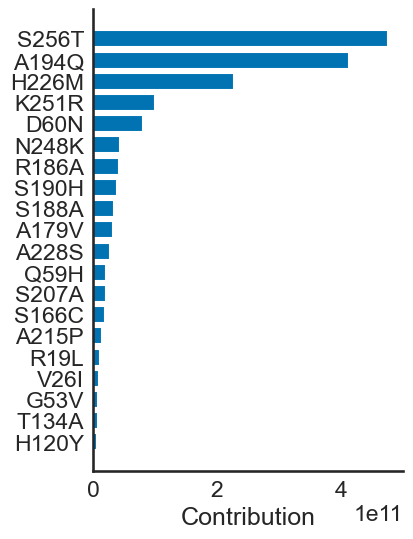

In [16]:
from utils import plot_style_utils
import matplotlib.pyplot as plt

plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax((4, 6))
plot_style_utils.prettify_ax(ax)

ax.barh( pos_features.head(20).feature[::-1], pos_features.head(20).contributions[::-1], color=plot_style_utils.CAT_PALETTE[0], )
ax.set_xlabel('Contribution')
plot_style_utils.save_for_pub(fig=fig, path='figures/round2/act_contri_mlp_model')

## XGBoost + SHAP

In [17]:
import xgboost
import shap

model = xgboost.XGBRegressor()
model.fit(X_not_na, Y_not_na,)

Y_pred = model.predict(X_not_na)
spearmanr(Y_not_na, Y_pred)

/home/xux/miniconda3/envs/prot-gen-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SignificanceResult(statistic=0.6915716506175417, pvalue=0.0)

In [18]:
explainer = shap.explainers.Permutation(model.predict, X_not_na)

shap_values = explainer(X_not_na)


PermutationExplainer explainer: 2415it [31:45,  1.26it/s]                          


In [19]:
import numpy as np

vals = np.abs(shap_values.values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_not_na.columns, vals)), columns=['feature','contributions'])
feature_importance.sort_values(by=['contributions'], ascending=False, inplace=True)
feature_importance.head()

,feature,contributions
179,A169G,0.030724
204,A152S,0.027829
273,S3T,0.019287
553,Y209L,0.012885
229,T213A,0.011195


In [20]:
useful_features = feature_importance[feature_importance.contributions > 1e-6]
len(useful_features)

238

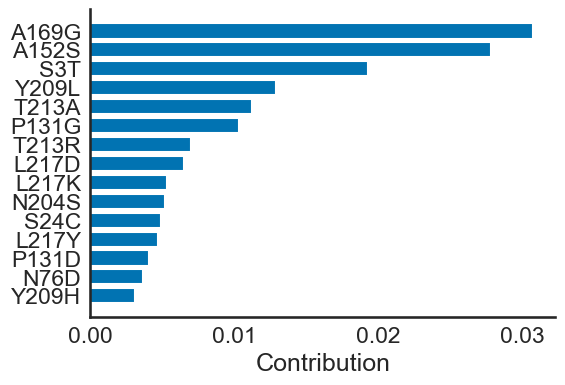

In [21]:
from utils import plot_style_utils
import matplotlib.pyplot as plt

plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax((6, 4))
plot_style_utils.prettify_ax(ax)
topn = 15

ax.barh(useful_features.head(topn).feature[::-1], useful_features.head(topn).contributions[::-1], color=plot_style_utils.CAT_PALETTE[0])
ax.set_xlabel('Contribution', )
plot_style_utils.save_for_pub(fig=fig, path='figures/round2/act_contri_xgb_shap_model')

## Intersect MLP pos and XGB useful mutations as the pool to expand

In [22]:
useful_mutations = set(useful_features.feature.tolist()).intersection(set(pos_features.feature.tolist()))

len(useful_mutations)

78

In [23]:
df_new_muts_useful = df_new_muts[df_new_muts.mutation.isin(useful_mutations)].copy()

len(df_new_muts_useful)

54

In [24]:
# get all mutant fitness of the useful mutations

new_useful_muts_mutants = []
new_useful_muts_mutants_fitness = []

for mut in df_new_muts_useful.mutation:
    mut_mutants = df_library_merged_na[(~df_library_merged_na.savinase_mutations.isna()) & df_library_merged_na.savinase_mutations.str.contains(mut)]
    new_useful_muts_mutants.append(mut_mutants.savinase_mutations.tolist() if len(mut_mutants) > 0 else [])
    new_useful_muts_mutants_fitness.append(mut_mutants.mean_act.tolist() if len(mut_mutants) > 0 else [])

df_new_muts_useful['mutants'] = new_useful_muts_mutants
df_new_muts_useful['mutants_fitness'] = new_useful_muts_mutants_fitness
df_new_muts_useful['mean_fitness'] = [np.mean(fitness) if len(fitness) > 0 else np.nan for fitness in df_new_muts_useful.mutants_fitness]
df_new_muts_useful

,ref,pos,mut,sav_pos,mutation,mutants,mutants_fitness,mean_fitness
8,W,6,C,6,W6C,[W6C/N43R/A98G/P131S/Y209F/T213Y/N218S/T224A/S...,"[1.7903820156648, 0.0596]",0.924991
136,S,9,G,9,S9G,[S3A/S9G/A98S/N204S/Y209H/T213E/L217M/N218S/T2...,"[2.3746, 0.015]",1.194800
224,Q,12,K,12,Q12K,[S3T/Q12K/N43K/P131G/Y209L/T213A/N218S/T224A/S...,"[2.51000689216414, 2.08075555252002]",2.295381
150,A,13,V,13,A13V,[S3V/A13V/N76D/A98S/A169G/Y209H/T213R/N218S/T2...,[2.06242541298058],2.062425
196,P,14,S,14,P14S,[S3T/P14S/N43K/A98S/P131T/A152S/Y209L/T213A/N2...,"[2.27495037404029, 1.0066894374199]",1.640820
231,H,17,Y,17,H17Y,[S3V/H17Y/N43K/N76D/N204D/Y209H/T213E/N218S/T2...,"[2.5951, 1.7190726233286, 0.894225363881904]",1.736133
130,G,25,D,25,G25D,[S3T/S24C/G25D/A98S/P131D/A169G/Y209H/T213A/N2...,"[2.48700127334465, 1.7877746632148]",2.137388
167,P,52,S,51,P52S,[S3T/S24C/N43R/P52S/P131D/Y209H/T213A/N218S/T2...,[2.90528911872725],2.905289
134,Q,59,K,57,Q59K,[S3T/Q59K/P131T/A152S/Y209H/T213A/N218S/T224A/...,"[2.34558993066421, 1.7505, 1.277]",1.791030
156,G,61,V,59,G61V,[S3L/S24P/G61V/A98S/A169G/Q206P/Y209H/T213R/N2...,[2.1007173470562],2.100717


In [25]:
# drop if a mut has a mean fitness of smaller than 1
df_new_muts_useful = df_new_muts_useful[df_new_muts_useful.mean_fitness > 1]
df_new_muts_useful.to_csv('data/round2/hotspots/new_muts_useful.csv', index=False)
print(len(df_new_muts_useful))
df_new_muts_useful

52


,ref,pos,mut,sav_pos,mutation,mutants,mutants_fitness,mean_fitness
136,S,9,G,9,S9G,[S3A/S9G/A98S/N204S/Y209H/T213E/L217M/N218S/T2...,"[2.3746, 0.015]",1.194800
224,Q,12,K,12,Q12K,[S3T/Q12K/N43K/P131G/Y209L/T213A/N218S/T224A/S...,"[2.51000689216414, 2.08075555252002]",2.295381
150,A,13,V,13,A13V,[S3V/A13V/N76D/A98S/A169G/Y209H/T213R/N218S/T2...,[2.06242541298058],2.062425
196,P,14,S,14,P14S,[S3T/P14S/N43K/A98S/P131T/A152S/Y209L/T213A/N2...,"[2.27495037404029, 1.0066894374199]",1.640820
231,H,17,Y,17,H17Y,[S3V/H17Y/N43K/N76D/N204D/Y209H/T213E/N218S/T2...,"[2.5951, 1.7190726233286, 0.894225363881904]",1.736133
130,G,25,D,25,G25D,[S3T/S24C/G25D/A98S/P131D/A169G/Y209H/T213A/N2...,"[2.48700127334465, 1.7877746632148]",2.137388
167,P,52,S,51,P52S,[S3T/S24C/N43R/P52S/P131D/Y209H/T213A/N218S/T2...,[2.90528911872725],2.905289
134,Q,59,K,57,Q59K,[S3T/Q59K/P131T/A152S/Y209H/T213A/N218S/T224A/...,"[2.34558993066421, 1.7505, 1.277]",1.791030
156,G,61,V,59,G61V,[S3L/S24P/G61V/A98S/A169G/Q206P/Y209H/T213R/N2...,[2.1007173470562],2.100717
13,N,62,S,60,N62S,[S3T/N62S/N76D/N204D/Y209H/T213E/N218S/T224A/S...,"[2.9562, 2.88435926571759, 2.4224536007655, 1....",2.305118


# Identify new hotspots

## New positions from new mutations

In [26]:
pos_from_new_muts_useful = df_new_muts_useful.pos.unique().tolist()

new_pos_from_new_muts_useful = [pos for pos in pos_from_new_muts_useful if pos not in df_hotspot.pos.tolist()]

len(pos_from_new_muts_useful), len(new_pos_from_new_muts_useful)

(44, 44)

In [27]:
df_new_pos_from_new_muts_useful = pd.DataFrame(new_pos_from_new_muts_useful, columns=['pos'])

df_new_pos_from_new_muts_useful['new_muts'] = [df_new_muts_useful[df_new_muts_useful.pos == pos].mut.tolist() for pos in new_pos_from_new_muts_useful]

df_new_pos_from_new_muts_useful['sav_pos'] = convert_into_savinase_position(df_new_pos_from_new_muts_useful['pos'].values)
df_new_pos_from_new_muts_useful

,pos,new_muts,sav_pos
0,9,[G],9
1,12,[K],12
2,13,[V],13
3,14,[S],14
4,17,[Y],17
5,25,[D],25
6,52,[S],51
7,59,[K],57
8,61,[V],59
9,62,[S],60


## Top perplexity positions from MSA

In [28]:
import pandas as pd

df_align_freqs = pd.read_csv('data/round2/hotspots/alignment_frequencies.csv')
df_align_freqs['pos'] = df_align_freqs['i'] + 1
df_align_freqs.rename(columns={'i': 'index', 'A_i':'ref'}, inplace=True)

display(df_align_freqs.head())
print(df_align_freqs.columns)

,index,ref,conservation,-,A,C,D,E,F,G,...,N,P,Q,R,S,T,V,W,Y,pos
0,0,A,1.000,1.000,0.000,0.0,0.000,0.000,0.0,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,1
1,1,Q,0.910,0.946,0.000,0.0,0.000,0.004,0.0,0.000,...,0.000,0.000,0.016,0.027,0.000,0.000,0.000,0.0,0.000,2
2,2,S,0.736,0.838,0.021,0.0,0.019,0.014,0.0,0.002,...,0.028,0.001,0.019,0.004,0.026,0.013,0.001,0.0,0.000,3
3,3,V,0.591,0.742,0.040,0.0,0.011,0.013,0.0,0.002,...,0.017,0.006,0.033,0.021,0.017,0.019,0.025,0.0,0.009,4
4,4,P,0.550,0.648,0.009,0.0,0.035,0.035,0.0,0.004,...,0.012,0.073,0.115,0.003,0.026,0.026,0.000,0.0,0.001,5


Index(['index', 'ref', 'conservation', '-', 'A', 'C', 'D', 'E', 'F', 'G', 'H',
       'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'pos'],
      dtype='object')


In [29]:
# Sort the new positions by conservation of the wild-type, and take top 25
df_new_pos_from_new_muts_useful = df_new_pos_from_new_muts_useful.merge(df_align_freqs, left_on='sav_pos', right_on='pos', how='left')
df_new_pos_from_new_muts_useful.drop(columns=['index', 'pos_y'], inplace=True)
df_new_pos_from_new_muts_useful.sort_values(by='conservation', ascending=True, inplace=True)
df_new_pos_from_new_muts_useful.head(25)

,pos_x,new_muts,sav_pos,ref,conservation,-,A,C,D,E,...,M,N,P,Q,R,S,T,V,W,Y
7,59,[K],57,Q,0.059,0.055,0.048,0.011,0.102,0.056,...,0.043,0.046,0.030,0.043,0.109,0.074,0.091,0.046,0.005,0.044
17,130,"[L, T]",128,S,0.080,0.114,0.074,0.013,0.100,0.038,...,0.006,0.038,0.067,0.026,0.021,0.063,0.051,0.026,0.016,0.060
8,61,[V],59,G,0.083,0.054,0.046,0.080,0.139,0.081,...,0.006,0.056,0.029,0.019,0.035,0.058,0.071,0.042,0.011,0.027
42,259,"[G, I]",253,S,0.096,0.125,0.099,0.023,0.111,0.041,...,0.003,0.082,0.048,0.018,0.028,0.051,0.040,0.031,0.007,0.022
30,195,[E],189,G,0.102,0.015,0.060,0.055,0.024,0.041,...,0.006,0.093,0.015,0.037,0.057,0.179,0.127,0.051,0.041,0.052
27,185,"[Y, D]",179,N,0.103,0.004,0.103,0.001,0.038,0.068,...,0.013,0.086,0.007,0.098,0.096,0.058,0.090,0.065,0.002,0.018
38,240,[F],234,S,0.130,0.047,0.056,0.008,0.185,0.093,...,0.004,0.113,0.010,0.040,0.022,0.094,0.075,0.006,0.008,0.048
19,143,[I],141,T,0.139,0.016,0.107,0.002,0.007,0.035,...,0.047,0.020,0.001,0.020,0.152,0.059,0.074,0.178,0.029,0.054
13,99,[N],97,S,0.139,0.177,0.058,0.032,0.138,0.053,...,0.004,0.105,0.010,0.041,0.048,0.098,0.048,0.016,0.003,0.025
14,103,[P],101,S,0.162,0.010,0.044,0.001,0.105,0.050,...,0.005,0.052,0.035,0.030,0.040,0.162,0.190,0.010,0.007,0.113


In [30]:
nat_AAs = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
df_new_pos_from_new_muts_useful['top_5_aa'] = df_new_pos_from_new_muts_useful[nat_AAs].apply(lambda x: x.nlargest(5).index.tolist(), axis=1)
df_new_pos_from_new_muts_useful['mut_aas'] = df_new_pos_from_new_muts_useful.apply(lambda x: list(set(x['new_muts'] + x['top_5_aa'] + [x['ref']])), axis=1)

df_new_hotspots = df_new_pos_from_new_muts_useful[['pos_x', 'sav_pos', 'mut_aas']].copy()
df_new_hotspots.rename(columns={'pos_x': 'pos'}, inplace=True)
df_new_hotspots.to_csv('data/round2/hotspots/new_hotspots.csv', index=False)
df_new_hotspots

,pos,sav_pos,mut_aas
7,59,57,"[R, S, T, G, K, Q, D]"
17,130,128,"[S, T, G, L, P, D, A]"
8,61,59,"[T, G, C, V, E, D]"
42,259,253,"[S, G, L, I, N, D, A]"
30,195,189,"[S, T, G, E, N, A]"
27,185,179,"[R, T, N, K, Q, D, A, Y]"
38,240,234,"[S, F, T, E, N, D]"
19,143,141,"[R, T, V, I, A]"
13,99,97,"[S, G, N, D, A]"
14,103,101,"[S, F, T, P, D, Y]"


# Merge with prev hotspots

In [31]:
# Merge the new hotspots with the old hotspots
df_hotspot_R2 = pd.concat([df_hotspot, df_new_hotspots])
# check if there are any duplicates
df_hotspot_R2.drop_duplicates(subset=['pos'], inplace=True)
df_hotspot_R2.to_csv('data/round2/hotspots/hotspots_R2.csv', index=False)

len(df_hotspot_R2), len(df_new_hotspots), len(df_hotspot)

(69, 44, 25)

In [32]:
df_hotspot_R2 = pd.read_csv('data/round2/hotspots/hotspots_R2.csv')
df_hotspot_R2.sample(10)

,pos,mut_aas,sav_pos
65,88,"['S', 'T', 'C', 'V', 'A']",86
48,194,"['S', 'G', 'V', 'K', 'P', 'A']",188
8,124,"['C', 'I', 'L', 'M']",122
22,224,"['C', 'A', 'S']",218
62,114,"['S', 'L', 'V', 'I', 'A']",112
46,89,"['R', 'S', 'T', 'E', 'K', 'Q']",87
37,52,"['S', 'T', 'G', 'P', 'N', 'D']",51
23,256,"['G', 'N', 'R', 'Y', 'K']",250
56,13,"['L', 'V', 'I', 'Q', 'A']",13
44,117,"['S', 'K', 'H', 'N', 'D', 'Q']",115


In [33]:
# drop pos column and rename sav_pos to pos
df_hotspot_R2 = df_hotspot_R2.drop(columns=['pos'])
df_hotspot_R2.rename(columns={'sav_pos': 'pos'}, inplace=True)
df_hotspot_R2.to_csv('data/round2/hotspots/sav_hotspots_R2.csv', index=False)

In [34]:
size_search_space_log = np.sum([np.log(len(row.mut_aas.split(','))) for i, row in df_hotspot_R2.iterrows()])

print(f'number of positions: {len(df_hotspot_R2)}, search space size: {np.exp(size_search_space_log):.2e}')

number of positions: 69, search space size: 1.23e+51


# Visualize hotspots

In [35]:
df_hotspot = pd.read_csv('data/round2/hotspots/hotspots_R2.csv')
df_hotspot.sort_values(by='pos', inplace=True)
df_hotspot.head()

,pos,mut_aas,sav_pos
0,2,"['K', 'L', 'Q']",2
1,3,"['C', 'V', 'A', 'Y', 'L', 'T', 'S']",3
51,9,"['S', 'G', 'P', 'Q', 'D', 'A']",9
52,12,"['G', 'K', 'N', 'D', 'Q']",12
56,13,"['L', 'V', 'I', 'Q', 'A']",13


In [36]:
def convert_df_hotspot_to_heatmap_df(df_hotspot):
    NAT_AAS = list("ACDEFGHIKLMNPQRSTVWY")

    df_heatmap = pd.DataFrame(index=df_hotspot.pos, columns=NAT_AAS, data=0)
    for pos, mut_aas in zip(df_hotspot.pos, df_hotspot.mut_aas):
        for mut_aa in mut_aas:
            if mut_aa in NAT_AAS:
                df_heatmap.loc[pos, mut_aa] = 1
    df_heatmap = df_heatmap.astype(int)
    df_heatmap['pos'] = df_heatmap.index
    df_heatmap = df_heatmap.reset_index(drop=True)
    # transpose the dataframe for better visualization
    df_heatmap = df_heatmap.set_index('pos').T
    return df_heatmap
df_heatmap = convert_df_hotspot_to_heatmap_df(df_hotspot)
df_heatmap.head()

pos,2,3,9,12,13,14,17,24,25,43,...,230,234,240,243,245,248,256,259,265,271
A,0,1,1,0,1,0,0,0,0,0,...,1,1,0,1,1,1,0,1,1,1
C,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
D,0,0,1,1,0,1,0,0,1,1,...,0,0,1,0,1,1,0,1,0,0
E,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,1
F,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [37]:
df_hotspots_new = pd.read_csv('data/round2/hotspots/new_hotspots.csv')
display(df_hotspots_new.head())

# set value to 2 if the positin is in the new hotspots
for i, row in df_heatmap.iterrows():
    for pos in df_hotspots_new.pos:
        df_heatmap.loc[i, pos] = 2 if df_heatmap.loc[i, pos] == 1 else 0

df_heatmap

,pos,sav_pos,mut_aas
0,59,57,"['R', 'S', 'T', 'G', 'K', 'Q', 'D']"
1,130,128,"['S', 'T', 'G', 'L', 'P', 'D', 'A']"
2,61,59,"['T', 'G', 'C', 'V', 'E', 'D']"
3,259,253,"['S', 'G', 'L', 'I', 'N', 'D', 'A']"
4,195,189,"['S', 'T', 'G', 'E', 'N', 'A']"


pos,2,3,9,12,13,14,17,24,25,43,...,230,234,240,243,245,248,256,259,265,271
A,0,1,2,0,2,0,0,0,0,0,...,2,2,0,2,2,2,0,2,2,1
C,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
D,0,0,2,2,0,2,0,0,2,1,...,0,0,2,0,2,2,0,2,0,0
E,0,0,0,0,0,2,0,0,0,1,...,0,0,2,0,2,0,0,0,0,1
F,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,2,0
G,0,0,2,2,0,0,0,0,2,0,...,0,0,0,2,0,0,1,2,2,0
H,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,2,0,0,0,0
I,0,0,0,0,2,0,0,0,0,0,...,2,2,0,0,0,0,0,2,0,0
K,1,0,0,2,0,0,0,0,2,1,...,0,0,0,0,2,0,1,0,0,0
L,1,1,0,0,2,0,0,0,0,0,...,2,2,0,0,0,0,0,2,0,0


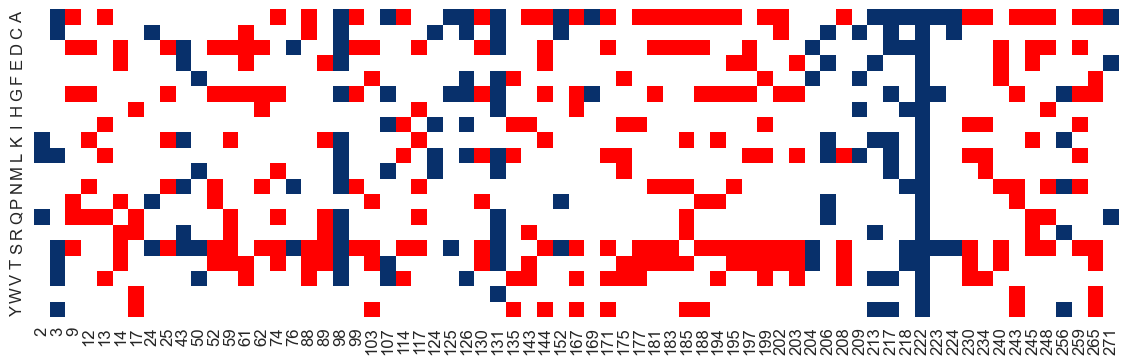

In [38]:
import matplotlib.pyplot as plt
from utils import plot_style_utils
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns

plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax(figsize=(14, 4))
plot_style_utils.prettify_ax(ax)

colors = ['#FFFFFF',    # White for 0 (Not Observed)
          '#08306b',    # Darkblue for 1, original hotspots 
          '#FF0000']    # Red for 2, new sites
cmap = ListedColormap(colors)

sns.heatmap(df_heatmap, cmap=cmap, cbar=False, ax=ax) # Label for the color bar
# plot the new hotspots in read on top of the heatmap
# sns.heatmap(df_heatmap_new, cmap='Reds', cbar=False, ax=ax, alpha=0.5) # Label for the color bar

# show AAs on the y-axis
ax.set_yticks([x + 0.5 for x in range(len(df_heatmap.index))])  # Set y-ticks to the middle of each row
ax.set_yticklabels(df_heatmap.index, fontsize=12)  # Set y-t

ax.set_xticks([x+0.5 for x in range(len(df_heatmap.columns))])
ax.set_xticklabels(df_heatmap.columns, rotation=90, fontsize=12) # Set x-tick labels to the positions

ax.set_xlabel('')
ax.set_ylabel('')

plt.xticks(rotation=90) # Rotate x-axis labels for better readability if many positions

plot_style_utils.save_for_pub(fig, path='figures/round2/hotspot_r2_mutation_heatmap')